We use [`k_clique`](https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.algorithms.community.kclique.k_clique_communities.html) API provided by `networkx` to find overlapping communities in DP, ML and NC fields.

Ref:Gergely Palla, Imre Derényi, Illés Farkas1, and Tamás Vicsek, 
Uncovering the overlapping community structure of complex networks in nature and society Nature 435, 814-818, 2005, doi:10.1038/nature03607

Gephi is used to create fancy result pics.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
import networkx as nx

In [2]:
df = pd.read_csv('seven_topconf_papers.csv')

In [3]:
dp_df = df[df.field == 'DP']

In [4]:
ml_df = df[df.field == 'ML']

In [5]:
nc_df = df[df.field == 'NC']

In [6]:
selected_df = pd.concat((dp_df, ml_df, nc_df))

In [7]:
selected_df.author = selected_df.author.apply(lambda x: x.replace(', ', ','))

In [8]:
selected_df.shape

(34025, 6)

In [9]:
temp = []
for i in selected_df.author.values:
    temp.extend(i.split(','))
unique_authors = np.unique(temp)

In [10]:
len(unique_authors)

42747

In [11]:
author_info = pd.DataFrame(index=unique_authors)

In [12]:
initialize = np.zeros(len(author_info.index))

In [13]:
author_ml = dict(zip(list(author_info.index), initialize))
for index in ml_df.index:
    authors = ml_df.loc[index].author.split(', ')
    for author in authors:
        try:
            author_ml[author] += 1
        except:
            pass

author_info['ml_paper'] = map(lambda x: author_ml[x], author_info.index)

In [14]:
author_nc = dict(zip(list(author_info.index), initialize))
for index in nc_df.index:
    authors = nc_df.loc[index].author.split(', ')
    for author in authors:
        try:
            author_nc[author] += 1
        except:
            pass

author_info['nc_paper'] = map(lambda x: author_nc[x], author_info.index)

In [15]:
author_dp = dict(zip(list(author_info.index), initialize))
for index in dp_df.index:
    authors = dp_df.loc[index].author.split(', ')
    for author in authors:
        try:
            author_dp[author] += 1
        except:
            pass

author_info['dp_paper'] = map(lambda x: author_dp[x], author_info.index)

In [16]:
author_info['total_paper'] = author_info['ml_paper'] + author_info['nc_paper'] + author_info['dp_paper']

Drop authors who has less than 10 papers published.

In [17]:
selected_author = author_info[author_info.total_paper >= 10]

In [18]:
selected_author.shape

(1405, 4)

In [19]:
selected_author.sort_values('total_paper', ascending=False)[:20]

,ml_paper,nc_paper,dp_paper,total_paper
Michael I. Jordan,119.0,2.0,0.0,121.0
Donald F. Towsley,0.0,109.0,0.0,109.0
Yunhao Liu,0.0,63.0,25.0,88.0
Bernhard Schölkopf,79.0,0.0,0.0,79.0
Jie Wu 0001,0.0,34.0,41.0,75.0
Ness B. Shroff,0.0,73.0,0.0,73.0
Andrew Y. Ng,70.0,0.0,0.0,70.0
Zoubin Ghahramani,68.0,0.0,0.0,68.0
Dhabaleswar K. Panda,0.0,0.0,67.0,67.0
Rong Jin,66.0,0.0,0.0,66.0


In [20]:
field = []
for index in selected_author.index:
    author_info = selected_author.loc[index]
    max_field = max(author_info.ml_paper, author_info.nc_paper, author_info.dp_paper)
    if max_field == author_info.ml_paper:
        field.append('ML')
    elif max_field == author_info.nc_paper:
        field.append('NC')
    else:
        field.append('DP')
selected_author['field'] = field

In [21]:
selected_author.groupby('field').count()

,ml_paper,nc_paper,dp_paper,total_paper
field,,,,
DP,194,194,194,194
ML,753,753,753,753
NC,458,458,458,458


In [22]:
selected_author.head()

,ml_paper,nc_paper,dp_paper,total_paper,field
A. Robert Calderbank,4.0,7.0,0.0,11.0,NC
Aaron C. Courville,12.0,0.0,0.0,12.0,ML
Aarti Singh,13.0,1.0,0.0,14.0,ML
Abdul Sattar,18.0,0.0,0.0,18.0,ML
Abhinav Bhatele,0.0,0.0,11.0,11.0,DP


In [23]:
G = nx.Graph()

In [24]:
for i in selected_df.index:
    authors = selected_df.loc[i].author.split(',')
    for j in range(len(authors)):
        for k in range(j+1, len(authors)):
            try:
                G.add_edge(authors[j], authors[k])
                if G[authors[j]][authors[k]].has_key('weight'):
                    G[authors[j]][authors[k]]['weight'] += 1
                else:
                    G[authors[j]][authors[k]]['weight'] = 1
            except:
                print authors[j], authors[k], 'not added!'

In [25]:
len(G.nodes())

41339

In [26]:
to_delete = []
for node in G.node:
    if node not in selected_author.index:
        to_delete.append(node)

In [27]:
len(to_delete)

39934

In [28]:
G.remove_nodes_from(to_delete)

In [29]:
len(G.nodes())

1405

In [30]:
for node in G.nodes():
    G.node[node]['field'] = selected_author.loc[node].field

In [31]:
nx.write_gml(G, 'selected_scholar_coauthor_network.gml')

In [32]:
res = list(nx.k_clique_communities(G, 4))

In [33]:
len(res)

142

In [34]:
res = map(lambda x: list(x), res)

In [35]:
res = sorted(res, cmp=lambda x, y: cmp(len(y), len(x)))

In [36]:
def find_k_community(scholar):
    com = 0
    for community in res:
        if scholar in community:
            return 'C' + str(com)
        else:
            com += 1
    return 'NoCommunity'

In [37]:
for node in G.nodes():
    G.node[node]['community'] = find_k_community(node)

In [38]:
for community in res:
    for scholar in community:
        print scholar,
        print G.node[scholar]['field']
    print 

Kenji Fukumizu ML
Nello Cristianini ML
Christopher J. C. Burges ML
John Shawe-Taylor ML
Klaus-Robert Müller ML
Massimiliano Pontil ML
Léon Bottou ML
Laurent El Ghaoui ML
Arthur Gretton ML
Zaïd Harchaoui ML
Michael I. Jordan ML
Bharath K. Sriperumbudur ML
Bernhard Schölkopf ML
Dengyong Zhou ML
Chiranjib Bhattacharyya ML
Alex J. Smola ML
Robert C. Williamson ML
Karsten M. Borgwardt ML
Gert R. G. Lanckriet ML
Le Song ML
Francis R. Bach ML
Xinhua Zhang ML
Vladimir Vapnik ML
Alexander J. Smola ML
Gunnar Rätsch ML
Olivier Chapelle ML
John C. Platt ML
Peter L. Bartlett ML
Tomaso Poggio ML
Patrice Simard ML
Jason Weston ML

Michael Wooldridge ML
Piotr Faliszewski ML
Talal Rahwan ML
Vincent Conitzer ML
Makoto Yokoo ML
Craig Boutilier ML
Tuomas Sandholm ML
Milind Tambe ML
Edith Elkind ML
Albert Xin Jiang ML
David C. Parkes ML
Tomasz P. Michalak ML
Jeffrey S. Rosenschein ML
Ariel D. Procaccia ML
Zinovi Rabinovich ML
Jérôme Lang ML
Svetlana Obraztsova ML
Moshe Tennenholtz ML
Yoram Bachrach ML
Atsu

In [39]:
nx.write_gml(G, 'k_clique_res.gml')

In [41]:
community_size = map(lambda x: len(x), res)

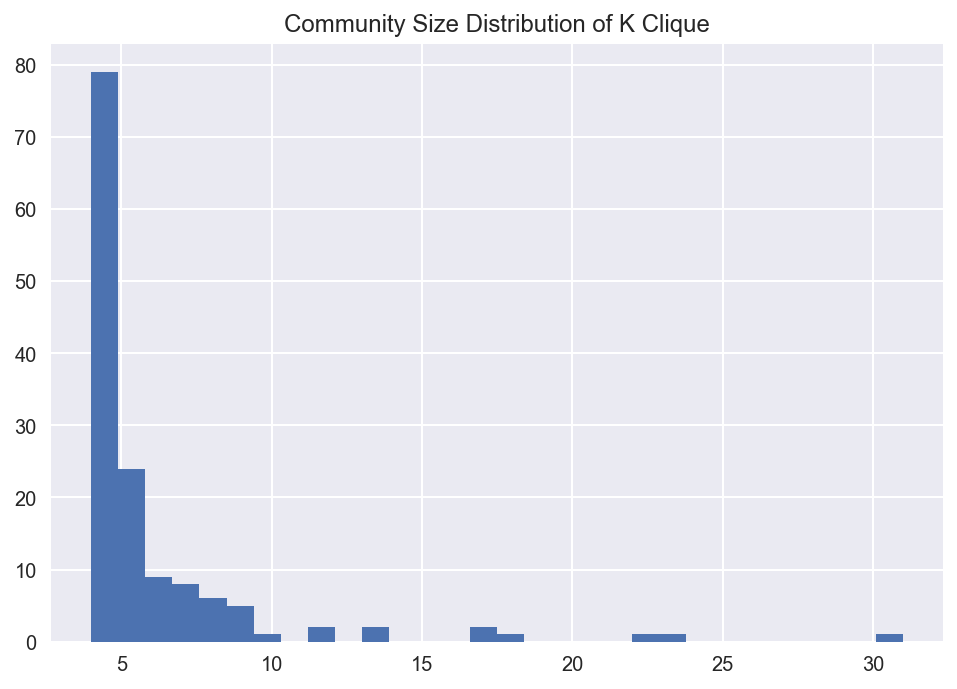

In [44]:
plt.hist(community_size, bins=30)
plt.title('Community Size Distribution of K Clique')

In [46]:
community_size = np.array(community_size)

In [50]:
sum(community_size > 30)

1

In [51]:
sum(community_size > 20)

3

In [52]:
sum(community_size > 10)

10

In [53]:
sum(community_size > 5)

39